This notebook converts [Ilya Kuprov's Matlab NMR simulation](http://spindynamics.org/Spin-Dynamics---Part-II---Lecture-06.php) for an n-spin-$\frac{1}{2}$ system to a Python simulation using the [QuTiP](http://qutip.org) library.

The QuTiP library seems to offer some convenience, plus possibly some sparse matrix manipulations that SciPy doesn't. However, relying on it would add another dependency to NMR projects. This notebook is a worksheet for learning how to simulate FT-NMR experiments, while learning QuTiP as well.

In [1]:
import numpy as np
import qutip
from scipy.linalg import expm
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.nan)

In [2]:
# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()


Loading BokehJS ...

Default frequencies and couplings from WINDNMR for 8-spin system:


In [3]:
def spin8():
    v = np.array([85, 120, 160, 185, 205, 215, 235, 260])
    J = lil_matrix((8, 8))
    J[0, 1] = -12
    J[0, 2] = 6
    J[0, 3] = 2
    # J[0, 4] = 0
    # J[0, 5] = 0
    # J[0, 6] = 0
    # J[0, 7] = 0
    # J[1, 2] = 0
    # J[1, 3] = 0
    J[1, 4] = 14
    # J[1, 5] = 0
    # J[1, 6] = 0
    J[1, 7] = 3
    # J[2, 3] = 0
    # J[2, 4] = 0
    J[2, 5] = 3
    # J[2, 6] = 0
    # J[2, 7] = 0
    # J[3, 4] = 0
    J[3, 5] = 5
    # J[3, 6] = 0
    # J[3, 7] = 0
    J[4, 5] = 2
    # J[4, 6] = 0
    # J[4, 7] = 0
    # J[5, 6] = 0
    # J[5, 7] = 0
    J[6, 7] = 12
    J = J + J.T
    return v, J

and for 2:
    

In [4]:
def spin2():
    v = np.array([150-7.5, 150+7.5])
    J = lil_matrix((2, 2))
    J[0, 1] = 12
    J = J + J.T
    return v, J

In [5]:
v, J = spin2()
v, J

(array([142.5, 157.5]), <2x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>)

In [6]:
sigma_x = (1/2) * qutip.sigmax()
sigma_y = (1/2) * qutip.sigmay()
sigma_z = (1/2) * qutip.sigmaz()
unit = qutip.qeye(2)
sigma_x, sigma_y, sigma_z, unit

(Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.  0.5]
  [0.5 0. ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j  0.-0.5j]
  [0.+0.5j 0.+0.j ]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 0.5  0. ]
  [ 0.  -0.5]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[1. 0.]
  [0. 1.]])

In [7]:
nspins = len(v)
Lx = np.empty(nspins, dtype='object')
Ly = np.empty(nspins, dtype='object')
Lz = np.empty(nspins, dtype='object')

Lx[0] = sigma_x
Ly[0] = sigma_y
Lz[0] = sigma_z
    
for n in range(1, len(v)):
    Lx[n] = unit
    Ly[n] = unit
    Lz[n] = unit

for n in range(0, nspins):
    print('n = ', n)
    for k in range(1, nspins):
        print('k = ', k)
        if k == n:
            Lx[n] = qutip.tensor(Lx[n], sigma_x)
            Ly[n] = qutip.tensor(Ly[n], sigma_y)
            Lz[n] = qutip.tensor(Lz[n], sigma_z)
        else:
            Lx[n] = qutip.tensor(Lx[n], unit)
            Ly[n] = qutip.tensor(Ly[n], unit)
            Lz[n] = qutip.tensor(Lz[n], unit)
     
Lz

n =  0
k =  1
n =  1
k =  1


array([Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.5  0.   0.   0. ]
 [ 0.   0.5  0.   0. ]
 [ 0.   0.  -0.5  0. ]
 [ 0.   0.   0.  -0.5]],
       Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.5  0.   0.   0. ]
 [ 0.  -0.5  0.   0. ]
 [ 0.   0.   0.5  0. ]
 [ 0.   0.   0.  -0.5]]], dtype=object)

In [8]:
H = Lz[0] * v[0]
for n in range(1, len(v)):
    H += Lz[n] * v[n]
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 150.     0.     0.     0. ]
 [   0.    -7.5    0.     0. ]
 [   0.     0.     7.5    0. ]
 [   0.     0.     0.  -150. ]]

In [9]:
for n in range(nspins):
    for k in range(nspins):
        if n != k:
            H += (J[(n, k)] / 2) * (Lx[n]*Lx[k] + Ly[n]*Ly[k] + Lz[n]*Lz[k])         
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 153.     0.     0.     0. ]
 [   0.   -10.5    6.     0. ]
 [   0.     6.     4.5    0. ]
 [   0.     0.     0.  -147. ]]

In [10]:
rho = sum(Lz)
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -1.]]

In [11]:
coil = sum(x + (0+1j)*y for x, y in zip(Lx, Ly))
coil

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 1. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]

In [12]:
Hp = sum(Ly)
Hp

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j  0.-0.5j 0.-0.5j 0.+0.j ]
 [0.+0.5j 0.+0.j  0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j  0.+0.j  0.-0.5j]
 [0.+0.j  0.+0.5j 0.+0.5j 0.+0.j ]]

Previous to writing this notebook, NMR spectra were constructed by taking the eigensolution of the spin Hamiltonian and extracting frequency and intensity values. Then, a Lorentzian lineshape  was created for each (frequency, intensity) signal. This can be thought of as a "continuous wave NMR" approach.

Instead, Kuprov's Matlab code continues from the spin Hamiltonian and models a hard 90° pulse, followed by detecting magnetization in the xy plane, creating a FID (free-induction decay) plot, and Fourier transforming it to provide a spectrum. This can be though of as the "FT-NMR" approach. Looking ahead to more complicated simulations (e.g. complex DNMR simulations; 2D NMR), this would be the more general approach.

I still have to work out how to have the final plot's x axis in frequency units with the signals plotting at the correct frequencies, and how to control the line width.



In [13]:
_ = (0-1j)*Hp*np.pi/2
# P_pulse = expm((0-1j)*Hp*np.pi/2)
P_pulse = _.expm()
P_pulse

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.5 -0.5 -0.5  0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5  0.5  0.5]]

In [14]:
print(H.norm(norm='max'))  # 'one' and 'max' match Matlab "normest" closest here
time_step = 1 / H.norm(norm='max')
time_step


153.0


0.006535947712418301

In [15]:
P_evol = ((0-1j)*H*time_step).expm()
P_evol


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[5.40302306e-01-0.84147098j 0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         9.96877926e-01+0.06854597j
  7.68380851e-04-0.0391824j  0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         7.68380851e-04-0.0391824j
  9.98798878e-01-0.02941003j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         5.72877307e-01+0.81964114j]]

In [16]:
P_pulse.tidyup()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.5 -0.5 -0.5  0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5  0.5  0.5]]

In [17]:
# CAUTION: .conj is NOT the complex conjugate transpose. Use .dag for that.
P_pulse.dag()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.5  0.5  0.5  0.5]
 [-0.5  0.5 -0.5  0.5]
 [-0.5 -0.5  0.5  0.5]
 [ 0.5 -0.5 -0.5  0.5]]

In [18]:
P_evol.tidyup()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[5.40302306e-01-0.84147098j 0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         9.96877926e-01+0.06854597j
  7.68380851e-04-0.0391824j  0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         7.68380851e-04-0.0391824j
  9.98798878e-01-0.02941003j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         5.72877307e-01+0.81964114j]]

In [19]:
rho = P_pulse*rho*P_pulse.dag()
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.5 0.5 0. ]
 [0.5 0.  0.  0.5]
 [0.5 0.  0.  0.5]
 [0.  0.5 0.5 0. ]]

In [20]:
nsteps = 2048
fid = np.zeros(nsteps, dtype=complex)
for step in np.nditer(fid, op_flags=['readwrite']):
    step[...] = (coil.dag()*rho).tr()
#     print(step)
    rho = P_evol * rho * P_evol.dag()
print(fid)

[ 2.00000000e+00+0.00000000e+00j  1.11205689e+00-1.65943677e+00j
 -7.56710868e-01-1.84096259e+00j -1.93890975e+00-3.93876635e-01j
 -1.39483796e+00+1.37979323e+00j  3.65756728e-01+1.90621564e+00j
  1.76384357e+00+7.47472312e-01j  1.57827541e+00-1.03304354e+00j
  2.00950777e-02-1.85296824e+00j -1.49777108e+00-1.02742798e+00j
 -1.65011450e+00+6.57438698e-01j -3.63462050e-01+1.69477285e+00j
  1.17387898e+00+1.21270392e+00j  1.61395812e+00-2.91569797e-01j
  6.36460728e-01-1.45767891e+00j -8.29176510e-01-1.29729567e+00j
 -1.48736732e+00-3.22642094e-02j -8.24632739e-01+1.17462571e+00j
  4.97726611e-01+1.28975519e+00j  1.29726654e+00+2.92962566e-01j
  9.27843799e-01-8.78850597e-01j -2.05028808e-01-1.20976452e+00j
 -1.07381161e+00-4.82785556e-01j -9.58107975e-01+5.97847585e-01j
 -3.52360299e-02+1.08269908e+00j  8.44207691e-01+6.06438867e-01j
  9.35023238e-01-3.49231069e-01j  2.21494714e-01-9.33566345e-01j
 -6.27924028e-01-6.77495458e-01j -8.80055920e-01+1.39350208e-01j
 -3.61742220e-01+7.818060

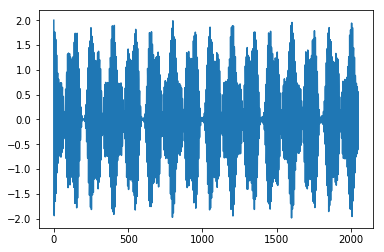

In [21]:
# before apodization
plt.plot(fid.real)
plt.show()

In [22]:
# apodization
window_function = np.exp(-5 * np.linspace(0, 1, 2048))
fid = np.multiply(fid, window_function)
fid[:20]

array([ 2.        +0.j        ,  1.1093439 -1.65538838j,
       -0.7530232 -1.83199105j, -1.92475375-0.39100094j,
       -1.3812762 +1.36637775j,  0.36131691+1.88307663j,
        1.73818189+0.73659754j,  1.55151915-1.01553051j,
        0.01970622-1.81711125j, -1.46520427-1.00508808j,
       -1.61029709+0.64157464j, -0.35382637+1.649843j  ,
        1.13997057+1.17767402j,  1.56351398-0.2824568j ,
        0.615064  -1.40867422j, -0.79934614-1.2506243j ,
       -1.43035988-0.03102759j, -0.79109174+1.12684914j,
        0.47631727+1.23427733j,  1.23843689+0.27967703j])

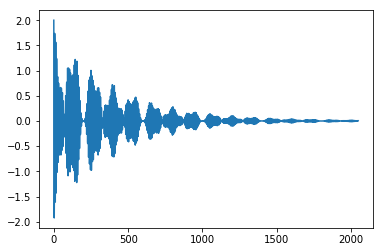

In [26]:
# after apodization
plt.plot(fid.real)
plt.show()

In [23]:
y = np.fft.fftshift(np.fft.fft(fid, 8196))
y


array([  0.99899183+5.33726015e-01j,   1.00124275+5.37123994e-01j,
         1.00415145+5.35369913e-01j,   1.00190759+5.32952201e-01j,
         0.99899382+5.35687539e-01j,   1.00123319+5.39099050e-01j,
         1.0041546 +5.37357357e-01j,   1.00192233+5.34927755e-01j,
         0.99899588+5.37652301e-01j,   1.00122363+5.41077313e-01j,
         1.00415772+5.39348074e-01j,   1.00193711+5.36906622e-01j,
         0.998998  +5.39620319e-01j,   1.00121407+5.43058803e-01j,
         1.00416081+5.41342083e-01j,   1.00195191+5.38888819e-01j,
         0.99900018+5.41591611e-01j,   1.00120451+5.45043536e-01j,
         1.00416386+5.43339401e-01j,   1.00196674+5.40874364e-01j,
         0.99900242+5.43566193e-01j,   1.00119495+5.47031529e-01j,
         1.00416688+5.45340045e-01j,   1.0019816 +5.42863274e-01j,
         0.99900473+5.45544084e-01j,   1.00118539+5.49022801e-01j,
         1.00416986+5.47344033e-01j,   1.00199649+5.44855568e-01j,
         0.9990071 +5.47525303e-01j,   1.00117584+5.51017369e-

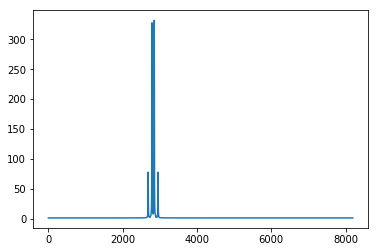

In [24]:
plt.plot(y.real)
plt.show()

In [25]:
# Make plot
p = bokeh.plotting.figure(plot_height=300,
                          plot_width=500,
                          x_axis_label='x',
                          y_axis_label='y')
x = [i for i, val in enumerate(y.real)]
p.line(x, y.real, line_width=2)

# Show the plot
bokeh.io.show(p)